<a href="https://colab.research.google.com/github/appersaravanan/AI_Assignment3/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import UpSampling2D,Input,BatchNormalization,Conv2D,Activation,Dropout,LeakyReLU,Flatten,Dense,Conv2DTranspose,Reshape

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
from random import randint
from keras.datasets import mnist
from tensorflow.data import Dataset
import time,os

from IPython import display




                                                                    

## Input is defined based on the mnist deminsion

In [25]:
#input shape. cifar images are 32*32 and with RGB color as 3
input_shape=(28,28,1)



#Discriminator layers as per the requirment.

In [26]:


def def_discriminator():
  d = Sequential();
  d.add(Conv2D(filters=32, kernel_size=(5, 5),  strides=(2,2) ,padding='same',input_shape=input_shape))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))

  d.add(Conv2D(filters=64, kernel_size=(5, 5),  strides=(2,2), padding='same'))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))

  d.add(Conv2D(filters=128, kernel_size=(5, 5),  strides=(2,2), padding='same'))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))

  d.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2,2), padding='same'))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))
  d.add(Flatten())
  d.add(Dense(1,activation='sigmoid'))
  
  return d;




#Generator is desigend as per requirement

In [27]:
dim=7
depth=192

def def_generator ():
  g= Sequential()

  g.add( Dense(dim*dim*depth,input_dim=100 )) 
  g.add( BatchNormalization())
  g.add( Activation('relu'))

  g.add( Reshape((dim, dim, depth)))
  g.add( Dropout(0.4))
  g.add(UpSampling2D((2, 2)))

  g.add( Conv2DTranspose(filters=96, kernel_size=(5, 5), strides=1, padding='same') )
  g.add(BatchNormalization())
  g.add( Activation('relu'))
  g.add( UpSampling2D((2, 2)))

  g.add( Conv2DTranspose(filters=48, kernel_size=(5, 5), strides=1, padding='same'))
  g.add(BatchNormalization())

  g.add( Activation('relu'))


  g.add(Conv2DTranspose(filters=24, kernel_size=(5, 5), strides=1, padding='same'))
  g.add( BatchNormalization())
  g.add( Activation('relu'))


  g.add( Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=1, padding='same')) 
  
  g.add(Activation('sigmoid'))
  

 

  return g;


In [28]:
in_batch_size=256
(x_train, y_train) ,(x_test, y_test) = mnist.load_data()
 


# Normalization
# Last layer is sigmoid so the normilization need to be (0,1)

In [29]:
batch_size=128
print(x_train.min() , x_train.max())
x_train = x_train- x_train.min() / x_train.max()- x_train.min()
x_train =x_train/255
print(x_train.min() , x_train.max())

x_train = np.expand_dims(x_train, axis=3) 


d_loss_real_list,d_loss_fake_list,d_acc_real_list,d_acc_fake_list,g_loss_list,d_loss_list=list(),list(),list(),list(),list(),list()

0 255
0.0 1.0


In [30]:

def train(epochs, batch_size=128, save_interval=50):
    alter=0;
    for epoch in range(epochs):
        half_batch = 64 #np.random.randint(in_batch_size, x_train.shape[0]/60)
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        imgs = x_train[idx] 

        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        
        real_1_labels,fake_0_lables =np.ones((half_batch, 1)),np.zeros((half_batch, 1) )

        real_1_labels_9 = real_1_labels * 0.9
        
        discriminator.trainable=True
       
        d_loss_real,d_acc_real = discriminator.train_on_batch(imgs, real_1_labels_9)
        d_loss_fake,d_acc_fake = discriminator.train_on_batch(gen_imgs, fake_0_lables )
        d_loss = np.add(d_loss_real, d_loss_fake) *0.5
        d_acc = np.add(d_acc_real, d_acc_fake) *0.5
        # print(""+str(d_loss_real) +"="+ str(d_loss_fake)+ "= "+str(d_loss))
        noise = np.random.normal(0, 1, (batch_size, 100)) 
        valid_y = np.array([1] * batch_size) 
        discriminator.trainable=False
        g_loss ,g_acc= combined.train_on_batch(noise, valid_y)

        #graph data
        d_loss_real_list.append(d_loss_real)
        d_loss_fake_list.append(d_loss_fake)
        d_acc_real_list.append(d_acc_real)
        d_acc_fake_list.append(d_acc_fake)
        g_loss_list.append(g_loss)
        d_loss_list.append(d_loss)
       
        if epoch % save_interval == 0 or (epoch == epochs or  epoch == epochs-1) :
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc, g_loss))
            show_imgs(epoch)





Method to display images that are generatored by generator during the traning at certain epochs

In [31]:
image_array=[]
def show_imgs(epoch):
    
    noise = np.random.normal(0, 1, (16, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
   
    fig, axs = plt.subplots(4, 4)
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    
    
    plt.show()

In [32]:
g_optimizer = Adam(0.0001,0.5) 
d_optimizer = Adam(0.001) 

Complie the only Discriminator and the GAN. We don't need a compliation config 
for generator because it is covered as part of GAN

0 [D loss: 0.887330, acc.: 0.00%] [G loss: 0.663005]


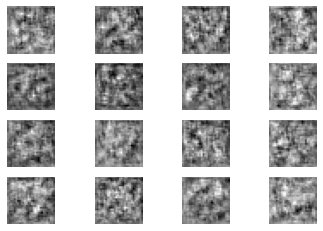

1000 [D loss: 0.335957, acc.: 46.09%] [G loss: 1.874766]


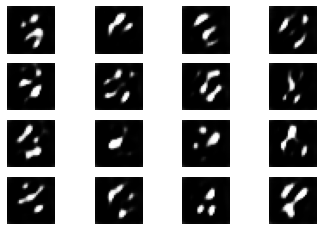

2000 [D loss: 0.578671, acc.: 39.84%] [G loss: 1.248502]


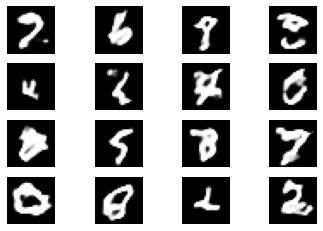

3000 [D loss: 0.626488, acc.: 42.97%] [G loss: 1.180722]


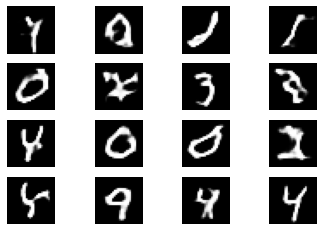

4000 [D loss: 0.637244, acc.: 35.16%] [G loss: 0.931946]


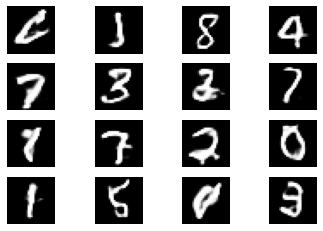

5000 [D loss: 0.654803, acc.: 40.62%] [G loss: 0.994169]


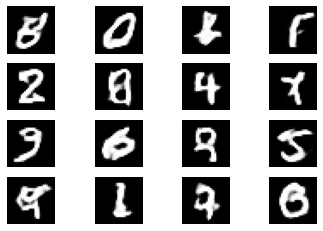

6000 [D loss: 0.696771, acc.: 32.03%] [G loss: 0.827385]


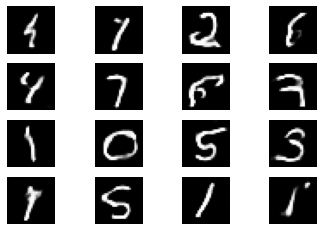

7000 [D loss: 0.673240, acc.: 34.38%] [G loss: 0.859298]


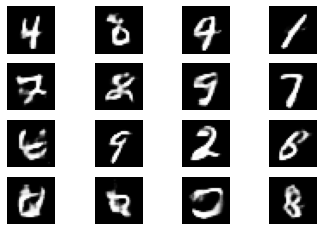

8000 [D loss: 0.676905, acc.: 39.06%] [G loss: 0.867439]


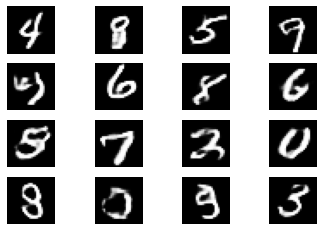

9000 [D loss: 0.683104, acc.: 36.72%] [G loss: 0.899030]


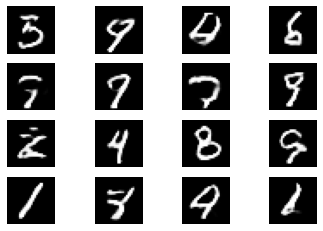

10000 [D loss: 0.659139, acc.: 42.97%] [G loss: 0.906666]


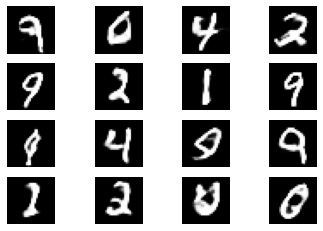

11000 [D loss: 0.715096, acc.: 32.03%] [G loss: 0.815293]


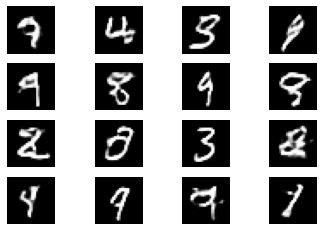

12000 [D loss: 0.687762, acc.: 39.84%] [G loss: 0.812226]


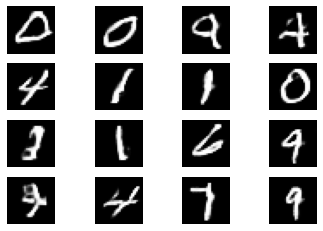

13000 [D loss: 0.678302, acc.: 36.72%] [G loss: 0.798976]


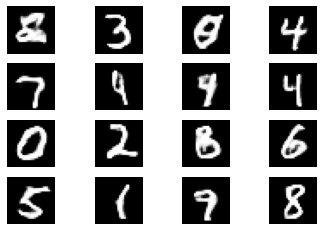

14000 [D loss: 0.687052, acc.: 35.94%] [G loss: 0.821338]


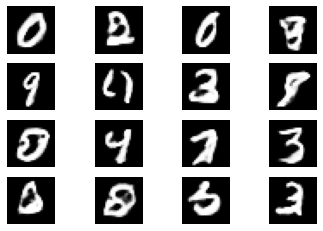

15000 [D loss: 0.670079, acc.: 40.62%] [G loss: 0.866960]


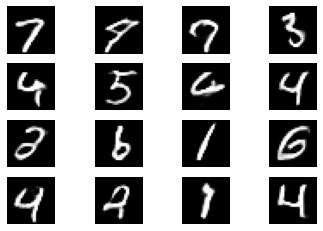

16000 [D loss: 0.689420, acc.: 34.38%] [G loss: 0.828556]


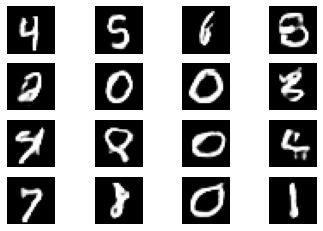

17000 [D loss: 0.685878, acc.: 39.84%] [G loss: 0.806319]


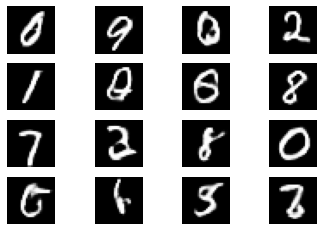

18000 [D loss: 0.688095, acc.: 40.62%] [G loss: 0.872544]


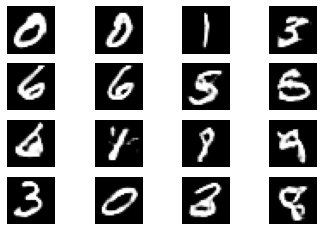

19000 [D loss: 0.678403, acc.: 40.62%] [G loss: 0.871994]


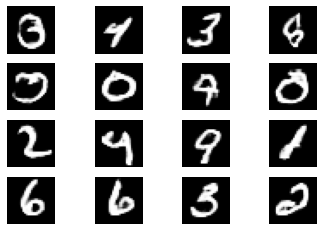

19999 [D loss: 0.716141, acc.: 30.47%] [G loss: 0.765789]


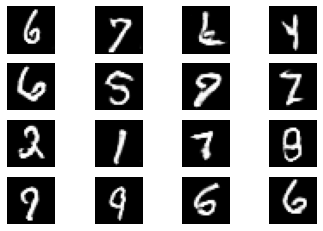

In [33]:
discriminator = def_discriminator()

discriminator.compile(loss='binary_crossentropy',optimizer=d_optimizer,metrics=['accuracy'])
generator = def_generator()
z = Input(shape=(100,))  
img = generator(z)
valid = discriminator(img) 

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=g_optimizer,metrics=['accuracy'])

train(epochs=20000, batch_size=in_batch_size, save_interval=1000)

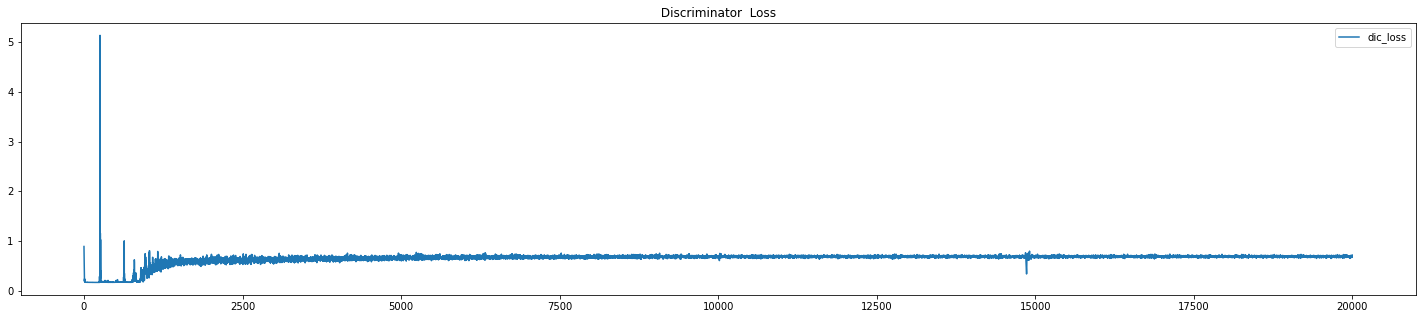

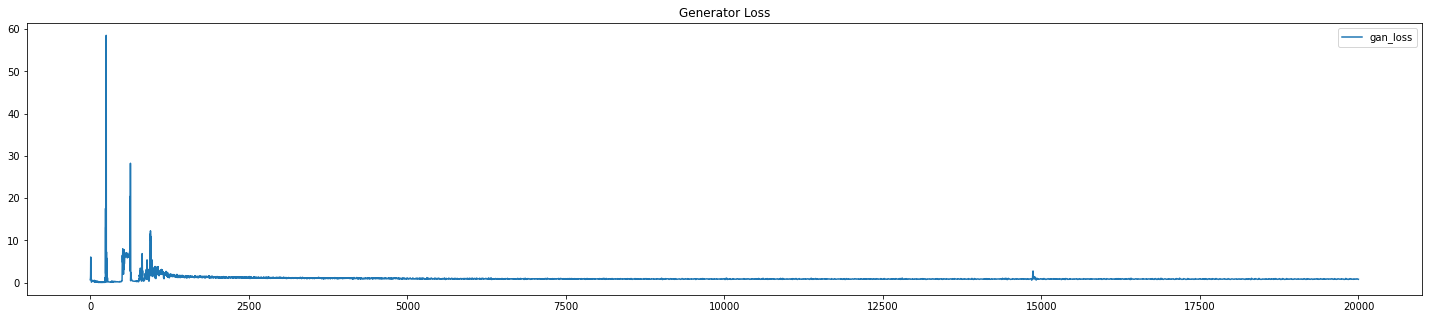

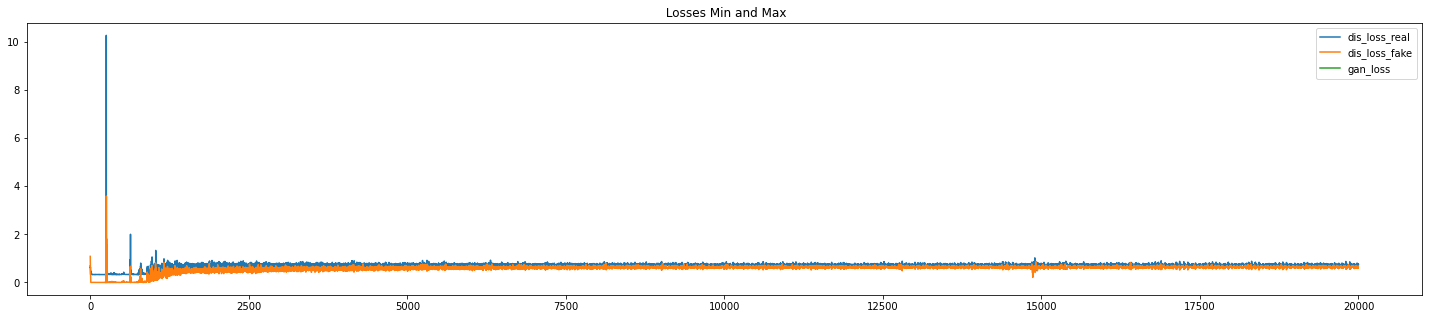

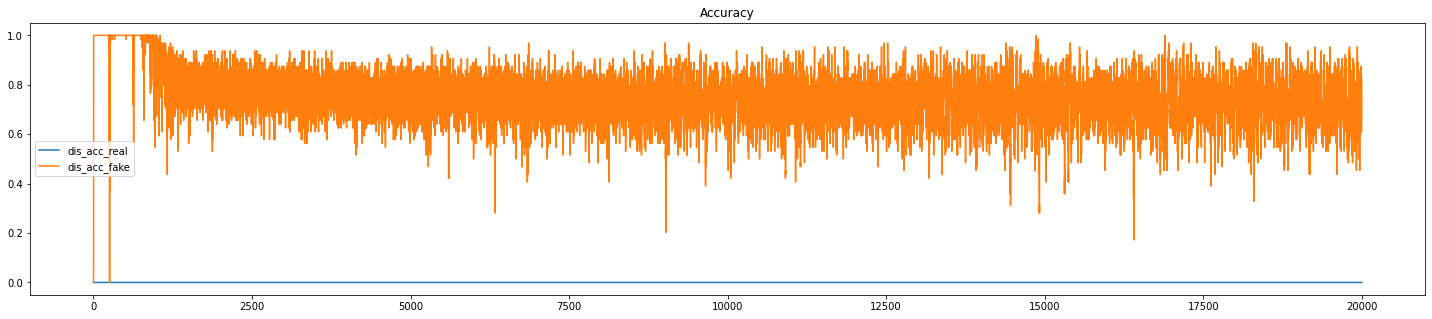

In [34]:

plt.subplots(figsize=(25, 5))

plt.plot(d_loss_list, label='dic_loss')
plt.title(" Discriminator  Loss ")
plt.legend()

plt.subplots(figsize=(25, 5))
plt.plot(g_loss_list, label='gan_loss')
plt.title("Generator Loss")
plt.legend()


plt.subplots(figsize=(25, 5))
plt.plot(d_loss_real_list, label='dis_loss_real')
plt.plot(d_loss_fake_list, label='dis_loss_fake')
plt.plot(g_loss_list[0], label='gan_loss')

plt.title(" Losses Min and Max")
plt.legend()


fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(d_acc_real_list, label='dis_acc_real')
plt.plot(d_acc_fake_list, label='dis_acc_fake')


plt.title("Accuracy")
plt.legend()


(28, 28)
[[0.4984796]]


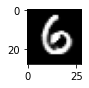

In [54]:
plt.subplots(figsize=(1, 1))
gen_imgs =  generator(np.random.randn(1,100)) 
pred_input= tf.reshape(gen_imgs,(28,28))
plt.imshow(pred_input,cmap="gray")
print(pred_input.shape)
pred_input= tf.reshape(pred_input,(1,28,28,1))
print(discriminator.predict(pred_input))